In [1]:
import torch
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from shapely import wkt
from tqdm import tqdm
from geopy.distance import great_circle
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

from tensorboardX import SummaryWriter
from datetime import datetime

tqdm.pandas()

In [2]:
class MigrationDataset_dimmies(InMemoryDataset):
    def __init__(self, root, transform=None):
        super(MigrationDataset_dimmies, self).__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = []
        for file in os.listdir(self.root):
            if file.endswith(".geojson") or file.endswith(".csv"):
                files.append(file)
        return files
        
    @property
    def processed_file_names(self):
        return ['migration_dataset']

    def download(self):
        pass
    
    def process(self):
        
        # read files in specified folder
        cities = gpd.read_file(os.path.join(self.root, "cities_aggregated_all.geojson"))
        responses = pd.read_parquet(os.path.join(self.root, "responses.gzip"))

        cities = cities.dropna().reset_index().set_index("region_city")
        # extract cities features 
        cities_features = cities[[
            # 'population',
            "city_category", 
            "harsh_climate", 
            "ueqi_residential", 
            "ueqi_street_networks", 
            "ueqi_green_spaces", 
            "ueqi_public_and_business_infrastructure", 
            "ueqi_social_and_leisure_infrastructure",
            "ueqi_citywide_space",
            "cvs_total",
            # "vacancies_total",
            "factories_total",
            'min_salary',
            'max_salary',
            'median_salary'
            ]]
        
        # cities_features['cvs_total'] = cities_features['cvs_total'] / cities_features['population']
        # cities_features['vacancies_total'] = cities_features['vacancies_total'] / cities_features['population']
        # cities_features = cities_features.drop(['population'], axis=1)

        # encode categorical features
        one_hot = OneHotEncoder(drop='first')
        encoded_category = one_hot.fit_transform(np.expand_dims(cities["city_category"].to_numpy(), 1)).toarray()
        encoded_category_names = one_hot.get_feature_names_out(["category"])
        cities_features.loc[:, encoded_category_names] = encoded_category
        cities_features = cities_features.drop(["city_category"], axis=1)
        cities_features["harsh_climate"] = cities_features["harsh_climate"].astype(int)

        DM = cities["geometry"].progress_apply(
                    lambda p1: cities["geometry"].apply(
                        lambda p2: great_circle((p1.coords[0][1],p1.coords[0][0]), (p2.coords[0][1],p2.coords[0][0])).km
                        ))

        # form origin-destination matrix
        responses_counts = responses.groupby(["cluster_center_cv", "cluster_center_vacancy"])["id_cv"].count()
        responses_cities = responses_counts.index.get_level_values(0).drop_duplicates()
        OD = pd.DataFrame(None, index=DM.columns, columns=DM.columns)
        OD = OD.progress_apply(
            lambda city: city.fillna(responses_counts[city.name]).fillna(0) 
            if city.name in responses_cities else city.fillna(0), axis=1
            )
        
        # transform data
        cities_num = len(OD)
        edge_index = [[], []]
        for i in range(cities_num):
            edge_index[0].extend([i for j in range(cities_num)])
            edge_index[1].extend([j for j in range(cities_num)])

        edge_index = torch.tensor(edge_index)
        y = torch.tensor(np.concatenate((OD.to_numpy())), dtype=torch.float32)
        edge_attr = torch.tensor(np.concatenate((DM.to_numpy())), dtype=torch.float32)
        x = torch.tensor(cities_features.to_numpy(), dtype=torch.float32)
        x_names = np.array(list(cities_features.index))

        #exclude diagonal
        # non_diagonal = edge_attr > 0
        # edge_attr = edge_attr[non_diagonal]
        # edge_index = edge_index[:, non_diagonal]
        # y = y[non_diagonal]
        
        # create torch object          
        graph = Data(x=x,edge_index=edge_index, y=y, edge_attr=edge_attr, x_names=x_names)
        
        data_list = []
        data_list.append(graph)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [3]:
dtst= MigrationDataset_dimmies("/var/essdata/IDU/other/mm_22/industrial-location/working_files/ml/data")
dt = dtst.data

/var/essdata/IDU/venvs/ml_venv/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [4]:
dt.x_names[dt.edge_index[:, (dt.y == dt.y.max()).nonzero()[0][0]][0]]

'Москва, Москва'

In [5]:
def split_train_test_new(x, edge_index, edge_weight, mask):

    x, edge_index, edge_weight = dt.x, dt.edge_index[:, mask], dt.edge_attr[mask].unsqueeze(-1)
    y = dt.y[mask]

    x_s = x[edge_index[0]]
    x_d = x[edge_index[1]]
    x = torch.cat((x_s, x_d, edge_weight), axis=1)

    return x, y

In [6]:
seeds = [40]
for seed in seeds:
    print('-'*60)
    print('manual seed ', seed)
    torch.manual_seed(seed)
    perm = torch.randperm(dt.num_edges)
    dt.train_idx = perm[:int(1 * dt.num_edges)]
    dt.test_idx = perm[int(0 * dt.num_edges):]
    X_train, y_train = split_train_test_new(dt.x, dt.edge_index, dt.edge_weight, dt.train_idx)
    X_test, y_test = split_train_test_new(dt.x, dt.edge_index, dt.edge_weight, dt.test_idx)

    train_data = Pool(data=X_train.numpy(), label=y_train.numpy())
    test_data = Pool(data=X_test.numpy(), label=y_test.numpy())

    cat = CatBoostRegressor(depth=7, l2_leaf_reg=20, learning_rate= 0.1, loss_function='RMSE', verbose=False, iterations=1500)
    cat.fit(train_data, eval_set=[train_data, test_data], plot=True)

    cat.save_model(f'./cat_model_dummies_{seed}',
        format="cbm",
        export_parameters=None,
        pool=None)

    test_predictions =  cat.predict(test_data)
    train_predictions =  cat.predict(train_data)

    print("CatBoost Test RMSE:", mean_squared_error(y_test.numpy(), test_predictions, squared=False), "\n"
        "CatBoost Test R2:", r2_score(y_test.numpy(), test_predictions), "\n\n"
        "CatBoost Train RMSE:", mean_squared_error(y_train.numpy(), train_predictions, squared=False), "\n"
        "CatBoost Train R2:", r2_score(y_train.numpy(), train_predictions))
    print("CatBoost RMSE score for negative edges:", mean_squared_error(y_test[y_test == 0].numpy(), test_predictions[y_test == 0], squared=False))
    print("CatBoost RMSE score for positive edges:", mean_squared_error(y_test[y_test > 0].numpy(), test_predictions[y_test > 0], squared=False))
    print()

------------------------------------------------------------
manual seed  40


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost Test RMSE: 1.9476716706163038 
CatBoost Test R2: 0.9853217339148586 

CatBoost Train RMSE: 1.9476716706163038 
CatBoost Train R2: 0.9853217339148586
CatBoost RMSE score for negative edges: 0.5248630478967867
CatBoost RMSE score for positive edges: 12.244158256733206



In [7]:
cities_features = ['harsh_climate', 'ueqi_residential', 'ueqi_street_networks',
       'ueqi_green_spaces', 'ueqi_public_and_business_infrastructure',
       'ueqi_social_and_leisure_infrastructure', 'ueqi_citywide_space',
       'cv_count', 'factories_total', 'min_salary',
       'max_salary', 'median_salary', 'category_Крупнейший город',
       'category_Крупный город', 'category_Малый город',
       'category_Средний город']

features = pd.DataFrame(
    list(X_train.numpy()), 
    columns= [i + '_from' for i in cities_features] + [i + '_to' for i in cities_features] + ["distance"]
    )

In [8]:
features

,harsh_climate_from,ueqi_residential_from,ueqi_street_networks_from,ueqi_green_spaces_from,ueqi_public_and_business_infrastructure_from,ueqi_social_and_leisure_infrastructure_from,ueqi_citywide_space_from,cv_count_from,factories_total_from,min_salary_from,...,cv_count_to,factories_total_to,min_salary_to,max_salary_to,median_salary_to,category_Крупнейший город_to,category_Крупный город_to,category_Малый город_to,category_Средний город_to,distance
0,1.0,21.0,24.0,13.0,23.0,22.0,36.0,557.0,1.0,9945.0,...,84.0,1.0,9489.0,50000.0,15000.0,0.0,0.0,1.0,0.0,3999.122803
1,0.0,44.0,37.0,34.0,33.0,25.0,41.0,234.0,0.0,7800.0,...,1114.0,5.0,7800.0,150000.0,15000.0,0.0,1.0,0.0,0.0,186.668503
2,0.0,29.0,33.0,25.0,32.0,39.0,35.0,485.0,0.0,8900.0,...,42.0,1.0,13750.0,50000.0,30000.0,0.0,0.0,1.0,0.0,1138.399780
3,0.0,26.0,27.0,18.0,30.0,23.0,37.0,187.0,0.0,6000.0,...,1086.0,4.0,8000.0,332384.0,24400.0,0.0,1.0,0.0,0.0,1434.734253
4,1.0,33.0,27.0,33.0,19.0,28.0,40.0,2115.0,0.0,10000.0,...,281.0,0.0,8175.0,36000.0,14000.0,0.0,0.0,1.0,0.0,2653.052246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083676,0.0,22.0,28.0,27.0,18.0,25.0,36.0,419.0,6.0,7500.0,...,24.0,0.0,7800.0,35000.0,13500.0,0.0,0.0,1.0,0.0,2603.836914
1083677,1.0,16.0,27.0,11.0,13.0,18.0,32.0,20.0,0.0,20000.0,...,78.0,1.0,7800.0,60000.0,28000.0,0.0,0.0,1.0,0.0,5586.225098
1083678,0.0,36.0,41.0,43.0,29.0,35.0,35.0,158.0,3.0,5582.0,...,2848.0,6.0,4000.0,160000.0,21500.0,0.0,1.0,0.0,0.0,4252.247070
1083679,0.0,24.0,37.0,24.0,26.0,41.0,39.0,1460.0,2.0,8700.0,...,911.0,2.0,8000.0,160000.0,20423.5,0.0,1.0,0.0,0.0,2117.084717


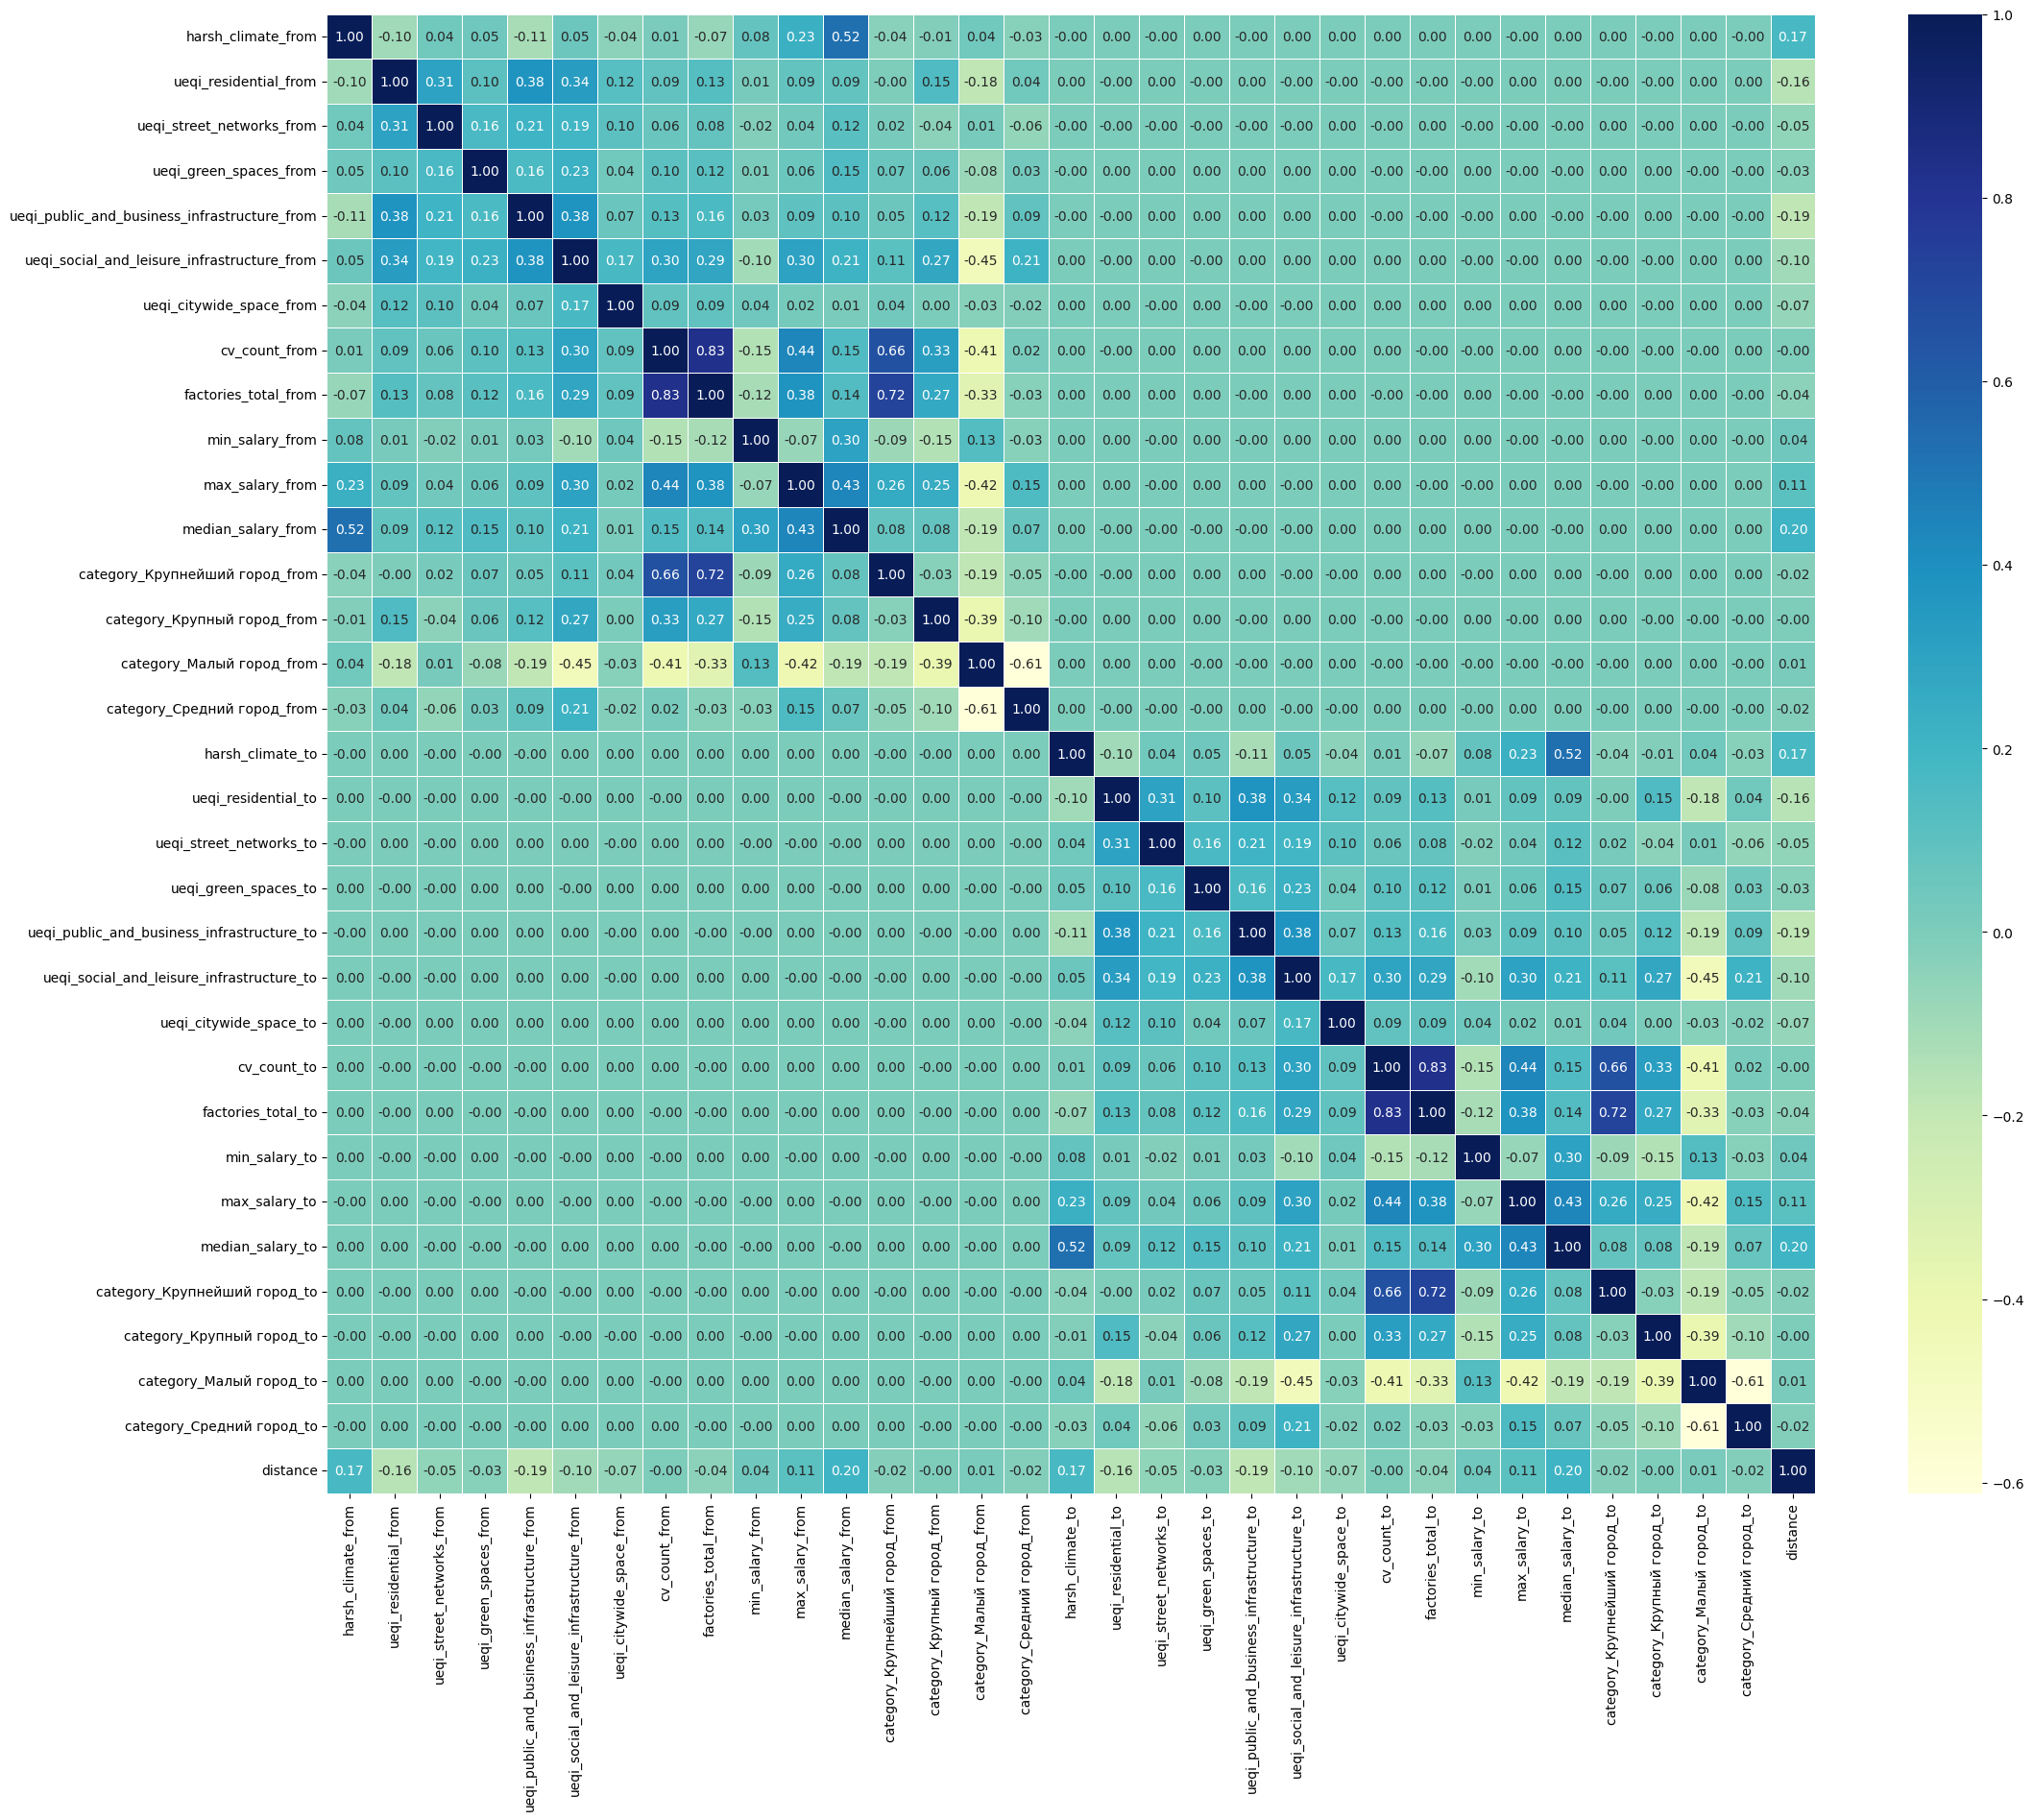

In [9]:
import seaborn as sns

corr_matrix = features.corr()
fig, ax = plt.subplots(figsize=(25, 20))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    linewidths=0.5,
    fmt=".2f",
    cmap="YlGnBu"
    )

In [10]:
import shap

explainer = shap.TreeExplainer(cat)
shap_values = explainer(features)

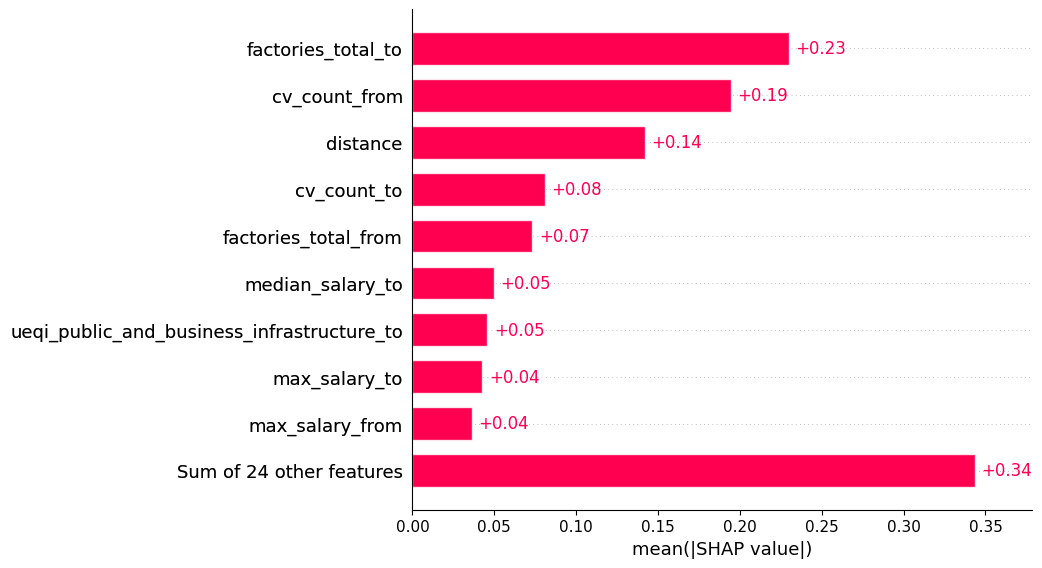

In [11]:
shap.plots.bar(shap_values)

In [12]:
shap_values

.values =
array([[ 5.81110900e-03, -2.10829341e-03,  1.26334531e-02, ...,
        -1.02850511e-02,  1.11702137e-03, -9.07724838e-02],
       [-4.51083629e-04, -9.89262432e-03,  1.50395220e-02, ...,
         1.85969989e-02,  3.56586971e-03,  4.96940429e-01],
       [-7.90991775e-04, -1.60577883e-03,  3.84977390e-04, ...,
        -1.15199085e-02,  1.30146551e-03, -3.65730076e-02],
       ...,
       [-2.54027642e-05, -8.53154811e-03,  3.57127800e-03, ...,
         4.56490039e-02,  2.96489469e-03, -1.55839424e-01],
       [-7.09290694e-04, -1.52393756e-02, -9.63673306e-03, ...,
         7.18555787e-02,  1.28030426e-02, -3.18822660e-01],
       [-4.36385416e-04,  1.35406402e-02, -4.48301150e-04, ...,
        -1.46674180e-02,  1.44070140e-03, -3.18708447e-02]])

.base_values =
array([0.30022703, 0.30022703, 0.30022703, ..., 0.30022703, 0.30022703,
       0.30022703])

.data =
array([[1.0000000e+00, 2.1000000e+01, 2.4000000e+01, ..., 1.0000000e+00,
        0.0000000e+00, 3.9991228e+03],
    

(-2.0, 2.0)

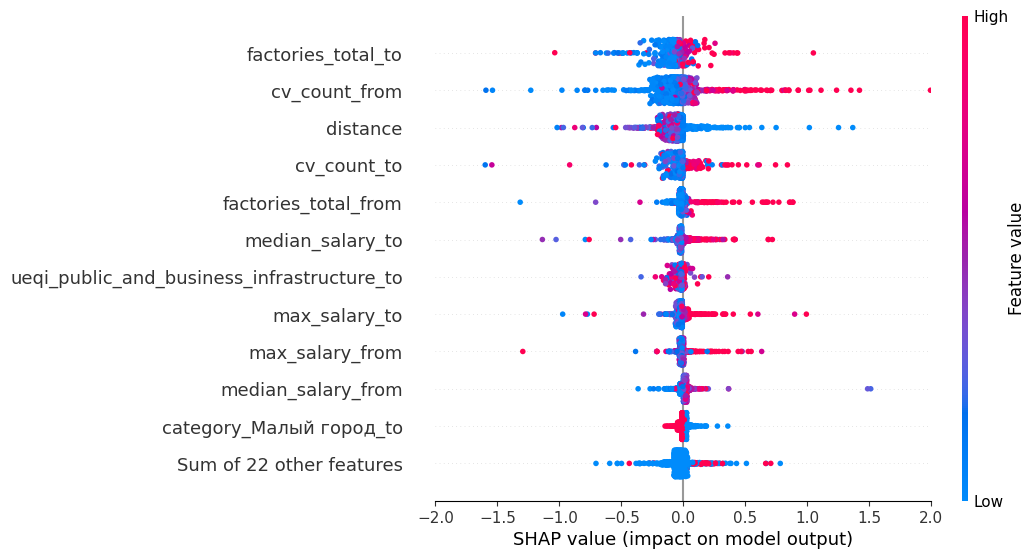

In [13]:
# приезжают в Казань

idx = (np.array(dt.x_names) == "Татарстан, Казань").nonzero()[0][0]
mask = dt.edge_index[1] == idx

shap.plots.beeswarm(shap_values[mask], show=False, max_display=12)

fig, ax = plt.gcf(), plt.gca()
xlim = 2
ax.set_xlim(-xlim, xlim)

(-2.0, 2.0)

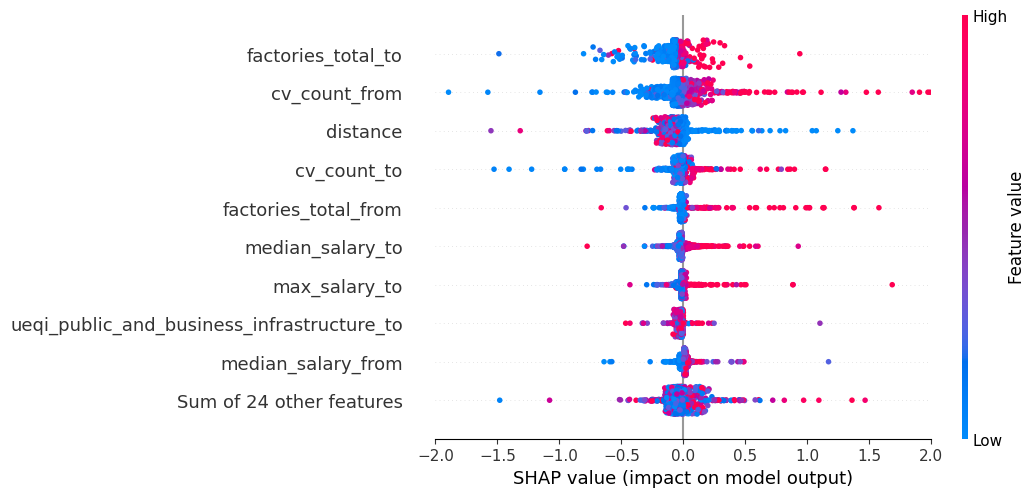

In [14]:
# приезжают в Томск

idx = (np.array(dt.x_names) == "Томская область, Томск").nonzero()[0][0]
mask = dt.edge_index[1] == idx

shap.plots.beeswarm(shap_values[mask], show=False)

fig, ax = plt.gcf(), plt.gca()
xlim = 2
ax.set_xlim(-xlim, xlim)

(-2.0, 2.0)

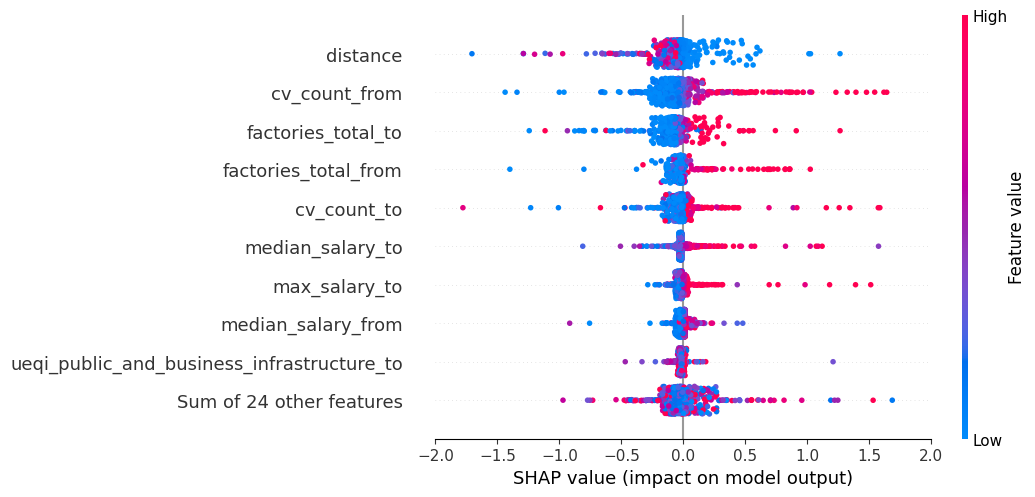

In [15]:
# уезжают из Томска

idx = (np.array(dt.x_names) == "Томская область, Томск").nonzero()[0][0]
mask = dt.edge_index[0] == idx

shap.plots.beeswarm(shap_values[mask], show=False)

fig, ax = plt.gcf(), plt.gca()
xlim = 2
ax.set_xlim(-xlim, xlim)